In [15]:
# Originally based on "Data Analysis 2D.ipynb"
# http://localhost:8888/notebooks/MPB/Data%20Analysis%202D.ipynb
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob

from libanalysis import *
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

<IPython.core.display.Javascript object>


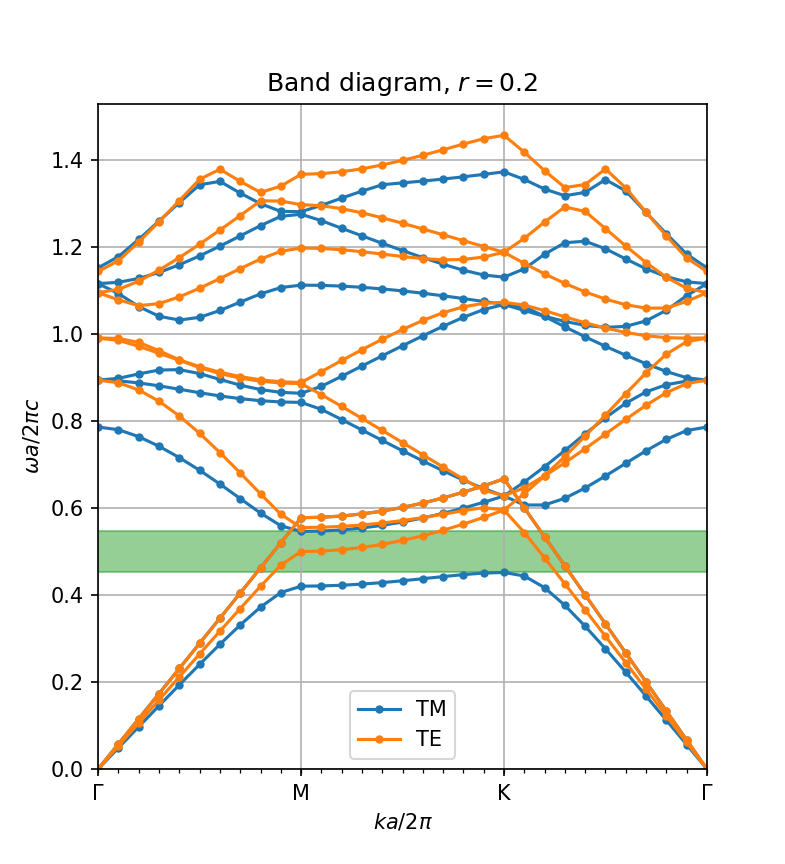

In [12]:
def plot_band_hex_cyl(numbands=8):
    '''
    numbands: number of bands plotted. The maximum input value is determined by the number of bands simulated in MPB
    '''
    tm_bands_import= np.genfromtxt("../Simulation-results/MPB/2d-hexagonal/glass-hexagonal-cyl-bands.tm.dat", skip_header=1, delimiter=",", dtype="str")
    te_bands_import= np.genfromtxt("../Simulation-results/MPB/2d-hexagonal/glass-hexagonal-cyl-bands.te.dat", skip_header=1, delimiter=",", dtype="str")
    tm_bands_data = tm_bands_import[:,5:].astype(float)
    te_bands_data = te_bands_import[:,5:].astype(float)

    fig = plt.figure( figsize= 1.2*plt.figaspect(1.1))
    ax1= fig.add_subplot(1,1,1)
    for tm_band in tm_bands_data.T[:numbands] :
        ax1.plot(tm_band, marker=".", linestyle="-", color='C0', label="TM")
    for te_band in te_bands_data.T[:numbands] :
        ax1.plot(te_band, marker=".", linestyle="-", color='C1', label="TE")

    ax1.set_ylabel(r"$\omega a / 2\pi c$")
    ax1.set_xlabel(r"$k a/2\pi$")
    ax1.set_xticklabels([])
    k_points = ["", r"$\Gamma$" , r"M", r"K", r"$\Gamma$"]

#     # http://stackoverflow.com/questions/30482727/pyplot-setting-grid-line-spacing-for-plot
#     #Spacing between each line
    intervals = float(10)
    loc = plticker.MultipleLocator(base=intervals)
    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_minor_locator(plticker.MultipleLocator(1))
    ax1.grid(which='major', axis='both', linestyle='-')
    ax1.set_xticklabels(k_points)
    ax1.legend()
    
    # plotting band gap
    band_gap_range=(np.min(tm_bands_data,axis=0)[2], np.max(tm_bands_data,axis=0)[1])
    polyCol = ax1.fill_between(np.arange(tm_bands_data.shape[0]), band_gap_range[0], band_gap_range[1], color='C2', alpha=0.5, zorder=-1) 
    
    ax1.set_title("Band diagram, $r=0.2$")
    ax1.set_ylim(ymin=0)
    ax1.set_xlim(xmin=0, xmax=tm_bands_data.shape[0]-1)

plot_band_hex_cyl()


<IPython.core.display.Javascript object>


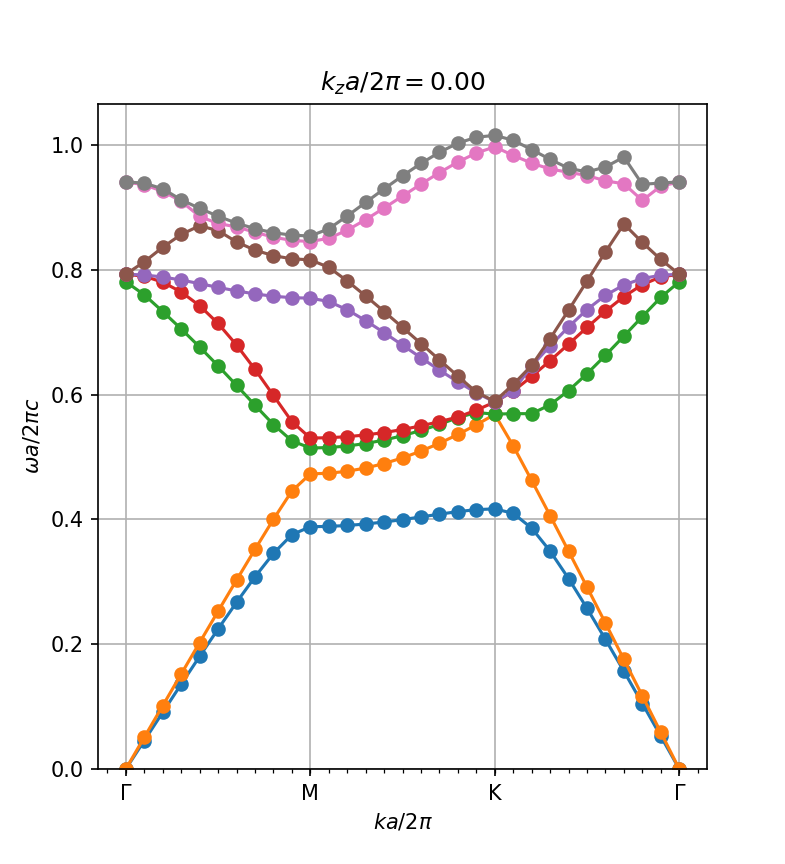

interactive(children=(IntSlider(value=0, description='index_kz', max=19), Output()), _dom_classes=('widget-interact',))

interactive(children=(Checkbox(value=True, description='Fix lower y limit at 0'), Output()), _dom_classes=('widget-interact',))

In [16]:
plot_bands_at_fixed_kz("../Simulation-results/MPB/2d-hexagonal/varied_k_z_optimized_r/", k_point_labels=[r"$\Gamma$", r"M", r"K", r"$\Gamma$"])

<IPython.core.display.Javascript object>


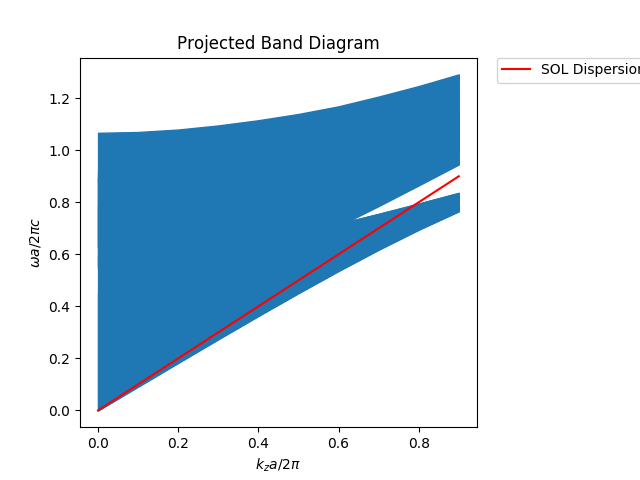

In [5]:
fig_projected, ax_projected = plot_projected_bands("../Simulation-results/MPB/2d-hexagonal/varied_k_z_r_0.2_old/")    

<IPython.core.display.Javascript object>


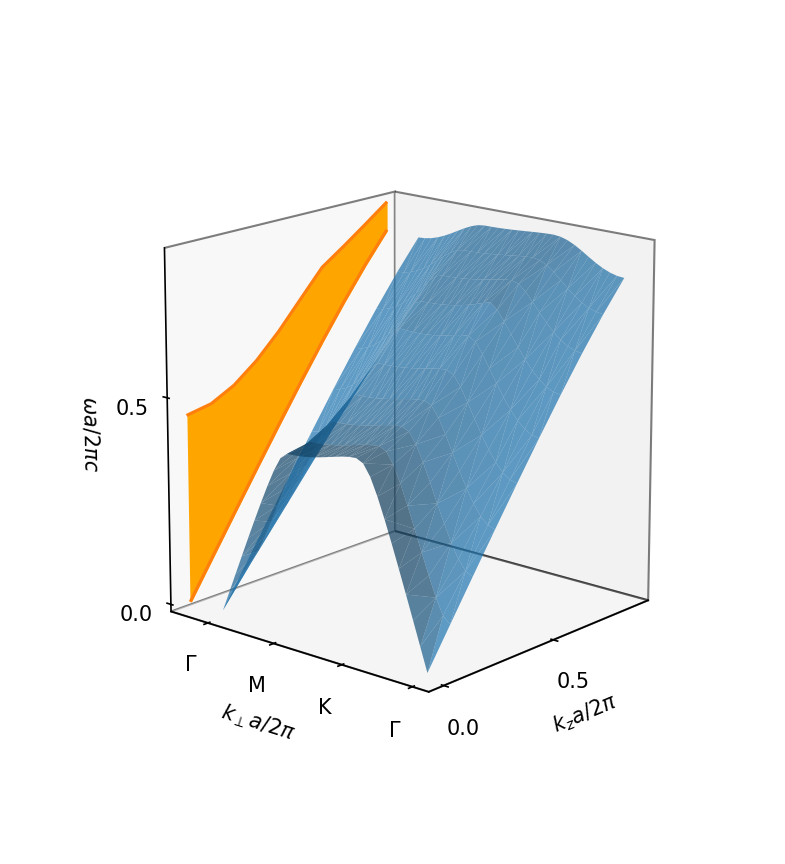

In [55]:
# further improvements on plot: https://dawes.wordpress.com/2014/06/27/publication-ready-3d-figures-from-matplotlib/
# from: https://stackoverflow.com/questions/36737053/mplot3d-fill-between-extends-over-axis-limits
from mpl_toolkits.mplot3d.art3d import Poly3DCollection # New import

def plot_single_band_all(fname, num_kz=10):
    '''
    fname: filename of the full set of frequencies together with the wavevectors. It has the following structure:
        for a fixed longitudinal wavevector kz the transverse wavector - those of the lattice periodicty - are 
        varied and the frequency is stored. After that the longitudinal wavevector is changed and for this kz the
        transverse components are varied again
    num_kz: number of kz over which the simulation was stepped
    '''
    # "2d-hexagonal/varied_k_z/"
    data= np.loadtxt(fname, delimiter=',')
    if data.shape[0] % num_kz != 0:
        print('wrong number of kz! break')
        return
    kz = np.unique(data[:,2])
    data= data.reshape(num_kz, data.shape[0]//num_kz, data.shape[1])
    num_kt = data.shape[1]    
    data= data[data[:,1,2].argsort()] 
    max_bands= np.max(data[:,:,3], axis=1)
    min_bands= np.min(data[:,:,3], axis=1)
    data= data.reshape(num_kz*num_kt, data.shape[2])
    
    fig = plt.figure( figsize= 1.2*plt.figaspect(1.1))
    ax= fig.add_subplot(1,1,1, projection='3d')
    
    # TODO
    # used for the transverse components
    x = np.mod(np.arange(data.shape[0]), num_kt)
    
    ax.plot_trisurf(x, data[:,2] , data[:,3], linewidth=0.2, antialiased=True, alpha=0.7)
    x_lower_lim=ax.get_xlim()[1]+5
    x_lower_lim=-5
    z_lim_lower, z_lim_upper =ax.get_zlim()
    
    # Plot projected band additionally
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    ax.plot(kz, min_bands, zs=x_lower_lim, zdir='x', color="C1")
    ax.plot(kz, max_bands, zs=x_lower_lim, zdir='x', color="C1")
    
    x=x_lower_lim*np.ones(kz.shape[0])
    
    verts = [(x[i],kz[i],max_bands[i]) for i in range(kz.shape[0])] +\
    [(x[-i-1],kz[-i-1],min_bands[-i-1]) for i in range(kz.shape[0])]    
    ax.add_collection3d(Poly3DCollection([verts],color='orange')) # Add a polygon instead of fill_between

    
    ax.set_xlim(xmin=x_lower_lim)
    ax.set_zlim((0, z_lim_upper))

    k_points = [r"$\Gamma$" , r"M", r"K", r"$\Gamma$"]
    num_interpolate= (data.shape[1]-len(k_points)+1)/ (len(k_points)-1)

    intervals = float(10)
    loc = plticker.MultipleLocator(base=intervals)
# #     # matplotlib.ticker.IndexLocator(base, offset)  would be better for index plotting
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_minor_locator(plticker.MultipleLocator(1))
    ax.grid(which='major', axis='both', linestyle='-')
    ax.set_xticklabels(k_points)
    
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    ax.locator_params(axis="z", nbins=3)
    ax.locator_params(axis="y", nbins=3)
        
    ax.set_zlabel(r"$\omega a / 2\pi c$")
    ax.set_xlabel(r"$k_{\perp} a/ 2\pi $")
    ax.set_ylabel(r"$k_z a/ 2\pi $")
    
    # Background
    ax.grid(False)
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
#     ax.xaxis.pane.fill = False
#     ax.yaxis.pane.fill = False
#     ax.zaxis.pane.fill = False
    # change z-axis position
    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                         tmp_planes[0], tmp_planes[1], 
                         tmp_planes[4], tmp_planes[5])
    ax.view_init(azim=(-49),elev=15)
    
    return ax
    
# #     interact(update_by_kz, index_kz=widgets.IntSlider(min=0,max=num_kz,step=1,value=0))
ax= plot_single_band_all('../Simulation-results/MPB/2d-hexagonal/varied_k_z_r_0.2_old/1.band.dat', num_kz=10)


<IPython.core.display.Javascript object>


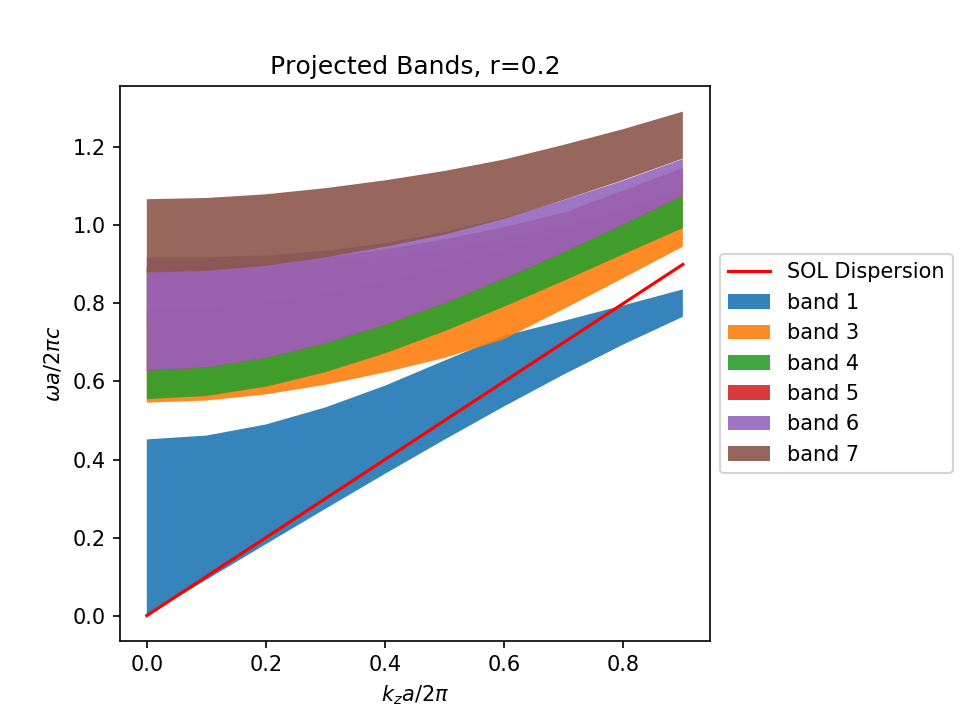

In [59]:
fig, ax= plot_projected_bands("../Simulation-results/MPB/2d-hexagonal/varied_k_z_r_0.2_old", 
                              sameColor=False, skipbands=[1], title="Projected Bands, r=0.2")

<IPython.core.display.Javascript object>


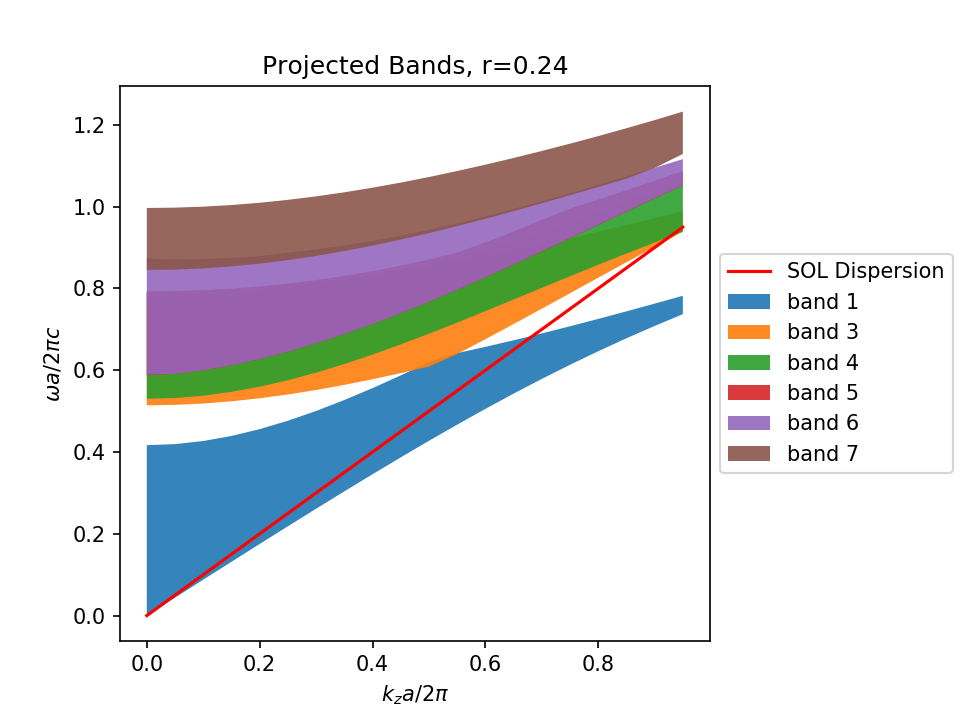

In [58]:
fig, ax= plot_projected_bands("../Simulation-results/MPB/2d-hexagonal/varied_k_z_optimized_r/", 
                              sameColor=False, skipbands=[1], title="Projected Bands, r=0.24")

In [ ]:
fig, ax= plot_projected_bands("../Simulation-results/MPB/2d-hexagonal/varied_k_z_/", 
                              sameColor=False, skipbands=[1], title="Projected Bands, r=0.2")